In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [3]:
data=pd.read_excel('/content/drive/MyDrive/NNFL data/Data_A2/data5.xlsx')

In [5]:
data[data.columns[-1]].unique()

array([1., 2., 3.])

In [6]:
data=data.sample(frac=1)
data.head()

,15.260,14.840,0.871,5.763,3.312,2.221,5.220,1.000
51,14.49,14.61,0.8538,5.715,3.113,4.116,5.396,1.0
83,19.51,16.71,0.8780,6.366,3.801,2.962,6.185,2.0
96,18.98,16.57,0.8687,6.449,3.552,2.144,6.453,2.0
3,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1.0
173,10.83,12.96,0.8099,5.278,2.641,5.182,5.185,3.0


In [7]:
class_one = data[data.iloc[:,-1]==1][0:210]
class_two = data[data.iloc[:,-1]==2][0:210]
class_three = data[data.iloc[:,-1]==3][0:210]

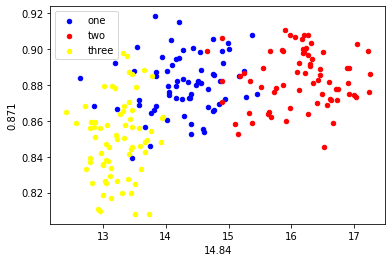

In [8]:
axes = class_one.plot(kind='scatter', x=1, y=2, color='blue', label='one')
class_two.plot(kind='scatter', x=1, y=2, color='red', label='two', ax=axes)
class_three.plot(kind='scatter', x=1, y=2, color='yellow', label='three', ax=axes)

In [9]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z)),Z

In [10]:
def relu(Z):
    A = np.maximum(0,Z)
    return Z,A

In [11]:
def relu_backward(dA, cache):
    Z = cache    
    dZ = np.array(dA, copy=True) 
    dZ[Z <= 0] = 0    
    return dZ

In [12]:
def sigmoid_backward(dA, cache):
    Z = cache    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

In [13]:
def initialize_parameters_deep(layer_dims):
    parameters = {}
    L = len(layer_dims)            
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
    return parameters

In [14]:
def linear_forward(A,W,b):
    Z = np.dot(W,A)+b
    cache = (A, W, b)
    return Z,cache

In [15]:
def linear_activation_forward(A_prev,W,b,activation):
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = relu(Z)
        
    cache = (linear_cache, activation_cache)
    
    return A,cache

In [16]:
def L_model_forward(X,parameters):
    caches = []
    A = X
    L = len(parameters) //2
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A,parameters['W'+str(l)],parameters['b'+str(l)],"sigmoid")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A,parameters['W'+str(L)],parameters['b'+str(L)],"sigmoid")
    caches.append(cache)

    return AL,caches

In [17]:
def compute_cost(AL,Y):
    m = Y.shape[1]
    cost = -(1/m)*np.sum(Y*np.log(AL)+(1-Y)*np.log(1-AL))
    cost = np.squeeze(cost)
    return cost

In [18]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = (1/m)*np.dot(dZ,A_prev.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)
   
    return dA_prev, dW, db

In [19]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    
    return dA_prev, dW, db

In [20]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) 
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 
    
    dAL = -(np.divide(Y,AL)-np.divide(1-Y,1-AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL,current_cache,"sigmoid")
   
    for l in reversed(range(L-1)):    
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA"+str(l+1)],current_cache,"sigmoid")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [21]:
def update_parameters(parameters, grads, learning_rate):
   
    L = len(parameters)//2
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-learning_rate*grads["dW"+str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-learning_rate*grads["db"+str(l+1)]
  
    return parameters

In [22]:
def L_layer_model(X, Y, layers_dims, learning_rate, num_iterations, print_cost=False):

    costs = []                      
 
    parameters = initialize_parameters_deep(layers_dims)

    for i in range(0, num_iterations):

        AL, caches = L_model_forward(X,parameters)
        cost = compute_cost(AL,Y)        
        grads = L_model_backward(AL,Y,caches)     
        parameters = update_parameters(parameters,grads,learning_rate)    
        costs.append(cost)
        
    plt.plot(np.squeeze(costs),'g')
    plt.ylabel('cost')
    plt.xlabel('Iterations')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters,costs

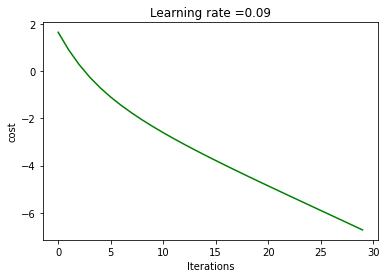

In [23]:
X=data.iloc[:,:-1].values
Y=data.iloc[:,-1].values
xmin=np.min(X,axis=0)
xmax=np.max(X,axis=0)
X=(X-xmin)/(xmax-xmin)#performing normalization on input features  
m=X.shape[0]
pp=np.ones([m,1])
X=np.append(pp,X,axis=1)
train_x,test_x,train_y,test_y=train_test_split(X,Y,test_size=0.2,train_size=0.8,shuffle=True)
train_x,valid_x,train_y,valid_y=train_test_split(train_x,train_y,test_size=0.125,train_size=0.875,shuffle=True)
train_x=train_x.T
train_y=train_y.T
train_y=np.reshape(train_y,newshape=(1,train_y.shape[0]))
layers_dims = [8,4,1]
parameters,costs = L_layer_model(train_x, train_y, layers_dims, 0.09, 30, print_cost = True)

In [24]:
def accuracy(parameters,test_x,test_acc):
    p,l=L_model_forward(test_x.T,parameters)
    p=(p>0.5).astype(int)
    a=test_acc-p
    a=np.sum((a!=0).astype(int))
    return (p.shape[1]-a)/p.shape[1]

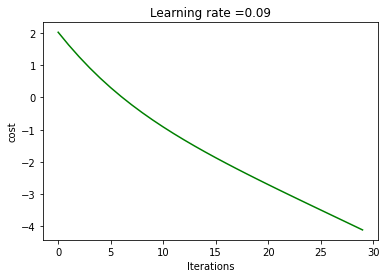

Fold: 1, Accuracy: -2700.0%


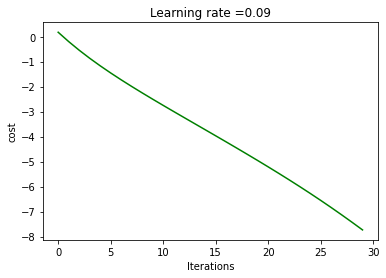

Fold: 2, Accuracy: -2800.0%


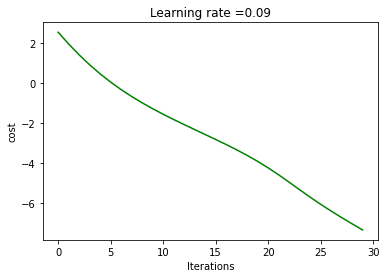

Fold: 3, Accuracy: -2700.0%


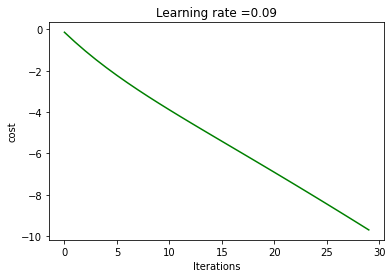

Fold: 4, Accuracy: -2700.0%


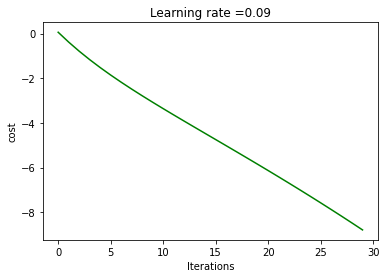

Fold: 5, Accuracy: -2600.0%
overall accuracy is for is: -2700.0


In [25]:
kf = KFold(n_splits=5)
X=data.iloc[:,:-1].values
X=(X-np.mean(X,axis=0))/(np.std(X,axis=0)) 
m=X.shape[0]
pp=np.ones([m,1])
X=np.append(pp,X,axis=1)

Y=data.iloc[:,-1].values
Y=np.reshape(Y,newshape=(-1,1))
layers_dims = [8,4,1]

kf.get_n_splits(X)
fold=0
acc=0
overall=0
for train_index, test_index in kf.split(X):
    fold+=1
    X_train=X[train_index]
    Y_train=Y[train_index]
    X_train=X_train.T 
    Y_train=Y_train.T
    Y_train=np.reshape(Y_train,newshape=(1,Y_train.shape[1]))
    X_test=X[test_index]
    Y_test=Y[test_index]
    parameters,costs = L_layer_model(X_train, Y_train, layers_dims, 0.09, 30, print_cost = False)
    acc=accuracy(parameters,X_test,Y_test)
    overall+=acc
    print("Fold: {0}, Accuracy: {1}%".format(fold,round(acc*100,2)))
print("overall accuracy is for is:",round(overall/5*100,2))